## 1. Packages and Parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from tqdm import tqdm
from utils.visualize import show_loss
from utils.data import collate_EP

import torch
import torch.nn as nn
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# hyperparameters
BATCH_SIZE = 256
EPOCH = 100
LEARNING_RATE = 2e-5
MAX_FRAME = 200
DIM_TOKEN = 256
NUM_HEAD = 8
DROPOUT_PROB = 1e-1

# dictionary for classification
dict_class = {
    'action': ['bodylower', 'bodyscratch', 'bodyshake',
               'feetup', 'footup', 'heading', 'lying',
               'mounting', 'sit', 'tailing', 'taillow',
               'turn', 'walkrun'],
    'emotion': ['aggresive', 'feared', 'anxiety',
                'relaxed', 'excited', 'offended'],
}
num_action = len(dict_class['action'])
num_emotion = len(dict_class['emotion'])

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

Device: cuda


## 2. Dataset

### 2.1 Load label

In [2]:
label_train = pd.read_pickle('data/key_label_train')
label_val = pd.read_pickle('data/key_label_val')

### 2.2 Dataset and dataloader

In [75]:
class KeyDataset(Dataset):
    def __init__(self, label):
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        keys, action, emotion = self.label.iloc[idx].values
        N, _, _ = keys.shape
        if N > 20:
            offset = np.random.randint(N-19)
            keys = keys[offset:offset+20]

        return keys, action, emotion

In [100]:
# dataset for training
train_dataset = KeyDataset(label_train)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_EP,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [79]:
# dataset for validation and test
temp_dataset = KeyDataset(label_val)

dataset_size = len(temp_dataset)
val_size = int(dataset_size * 0.5)
test_size = dataset_size - val_size

val_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_EP,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_EP,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

### 3.3 Check for a batch

In [101]:
train_keys = next(iter(train_dataloader))

In [102]:
print(train_keys.keys())
print(train_keys['keys'].shape)
print(train_keys['action'].shape)
print(train_keys['emotion'].shape)

dict_keys(['keys', 'action', 'emotion'])
torch.Size([256, 14, 15, 3])
torch.Size([256, 13])
torch.Size([256, 6])


## 3. Emotion Prediction
    - Input: ...
    - Output: ...

### 3.1 Model define

In [82]:
from torch.nn import TransformerEncoder as trEnc
from torch.nn import TransformerEncoderLayer as trEncLayer

In [83]:
class EPencoder(nn.Module):
    def __init__(self, C_in):
        super().__init__()
        
        # layers
        self.encoder_layer = trEncLayer(d_model=DIM_TOKEN,
                                        nhead=DIM_TOKEN // NUM_HEAD,
                                        activation='gelu',
                                        batch_first=True,
                                        norm_first=True)
        self.encoder = trEnc(encoder_layer=self.encoder_layer, 
                             num_layers=6)
        self.mlp_action = self.get_MLP(num_action)
        self.mlp_emotion = self.get_MLP(num_emotion)
        self.dropout = nn.Dropout(DROPOUT_PROB)
        self.linear = nn.Linear(C_in, DIM_TOKEN)
        
        # tokens
        self.pos_embedding = nn.Parameter(torch.randn(1, MAX_FRAME + 2, DIM_TOKEN))
        self.action_token = nn.Parameter(torch.randn(1, 1, DIM_TOKEN))
        self.emotion_token = nn.Parameter(torch.randn(1, 1, DIM_TOKEN))
        
    def get_MLP(self, len_cls):
        return nn.Sequential(nn.LayerNorm(DIM_TOKEN),
                             nn.Linear(DIM_TOKEN, len_cls),
                             nn.Softmax(1))

    def forward(self, x):   
        x = torch.flatten(x, 2) # [B, N, 15, 3] -> [B, N, 45]
        B, N, _ = x.shape             
        x = self.linear(x)      # [B, N, 45] -> [B, N, 256]
        
        act_token = self.action_token.repeat(B, 1, 1)
        emo_token = self.emotion_token.repeat(B, 1, 1)
        x = torch.cat((act_token, emo_token, x), dim=1)
        
        x += self.pos_embedding[:, :(N + 2)]
        x = self.dropout(x)
        
        x = self.encoder(x)
        
        act_output = x[:, 0]
        emo_output = x[:, 1]
        
        return self.mlp_action(act_output), self.mlp_emotion(emo_output)

In [84]:
model_EP = EPencoder(45)
model_EP = model_EP.double().to(device)

### 3.2 Training

In [11]:
model_EP = model_EP.train()

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model_EP.parameters(), lr=LEARNING_RATE)

train_avg_losses = []
train_accs_act = []
train_accs_emo = []
val_avg_losses = []
val_accs_act = []
val_accs_emo = []

In [33]:
for e in range(EPOCH):
    train_losses = []
    val_losses = []
    
    train_pos_act = 0
    train_pos_emo = 0
    val_pos_act = 0
    val_pos_emo = 0

    for train in train_dataloader:
        # Calculate loss and backpropagate
        optimizer.zero_grad()
        
        out_act, out_emo = model_EP(train['keys'].to(device))
        loss_act = criterion(out_act, train['action'].to(device))
        loss_emo = criterion(out_emo, train['emotion'].to(device))
        
        loss = loss_act + loss_emo
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Sum up positives
        with torch.no_grad():
            for i in range(len(out_act)):
                train_pos_act += train['action'][i, torch.argmax(out_act[i]).item()].item()
                train_pos_emo += train['emotion'][i, torch.argmax(out_emo[i]).item()].item()
        
    for val in val_dataloader:
        with torch.no_grad():
            out_act, out_emo = model_EP(val['keys'].to(device))
            loss_act = criterion(out_act, val['action'].to(device))
            loss_emo = criterion(out_emo, val['emotion'].to(device))

            loss = loss_act + loss_emo
            val_losses.append(loss.item())

            for i in range(len(out_act)):
                val_pos_act += val['action'][i, torch.argmax(out_act[i]).item()].item()
                val_pos_emo += val['emotion'][i, torch.argmax(out_emo[i]).item()].item()
    
    # Calculate average losses
    train_avg_loss = np.mean(np.array(train_losses))
    train_avg_losses.append(train_avg_loss)

    val_avg_loss = np.mean(np.array(val_losses))
    val_avg_losses.append(val_avg_loss)

    # Calculate accuracies
    train_acc_act = train_pos_act / len(train_dataset)
    train_accs_act.append(train_acc_act)
    train_acc_emo = train_pos_emo / len(train_dataset)
    train_accs_emo.append(train_acc_emo)

    val_acc_act = val_pos_act / len(val_dataset)
    val_accs_act.append(val_acc_act)
    val_acc_emo = val_pos_emo / len(val_dataset)
    val_accs_emo.append(val_acc_emo)

    if e % 5 == 0 or e == EPOCH-1:
        print(f'Epoch {e+1:>3}/{EPOCH} | {"Avg Train loss":<22}: {train_avg_loss:.4f} | {"Avg Val loss":<22}: {val_avg_loss:.4f} |',   
              f'{"|":>15} {"Train action accuracy":<22}: {train_acc_act:.4f} | Train emotion accuracy: {train_acc_emo:.4f} | ',
              f'{"|":>15} {"Val action accuracy":<22}: {val_acc_act:.4f} | {"Val emotion accuracy":<22}: {val_acc_emo:.4f} | ',
              sep='\n')

Epoch   1/100 | Avg Train loss        : 3.9065 | Avg Val loss          : 4.0302 |
              | Train action accuracy : 0.2972 | Train emotion accuracy: 0.5490 | 
              | Val action accuracy   : 0.1589 | Val emotion accuracy  : 0.5461 | 
Epoch   6/100 | Avg Train loss        : 3.7225 | Avg Val loss          : 4.0185 |
              | Train action accuracy : 0.4280 | Train emotion accuracy: 0.5693 | 
              | Val action accuracy   : 0.1589 | Val emotion accuracy  : 0.5469 | 
Epoch  11/100 | Avg Train loss        : 3.6977 | Avg Val loss          : 4.0114 |
              | Train action accuracy : 0.4397 | Train emotion accuracy: 0.5864 | 
              | Val action accuracy   : 0.1593 | Val emotion accuracy  : 0.5509 | 
Epoch  16/100 | Avg Train loss        : 3.6898 | Avg Val loss          : 4.0206 |
              | Train action accuracy : 0.4418 | Train emotion accuracy: 0.5924 | 
              | Val action accuracy   : 0.1593 | Val emotion accuracy  : 0.5513 | 
Epoch  2

In [44]:
#torch.cuda.empty_cache()

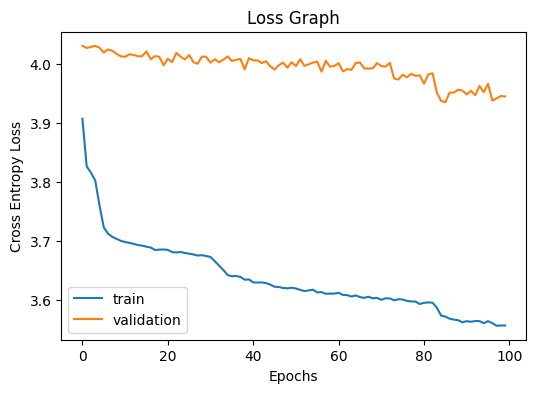

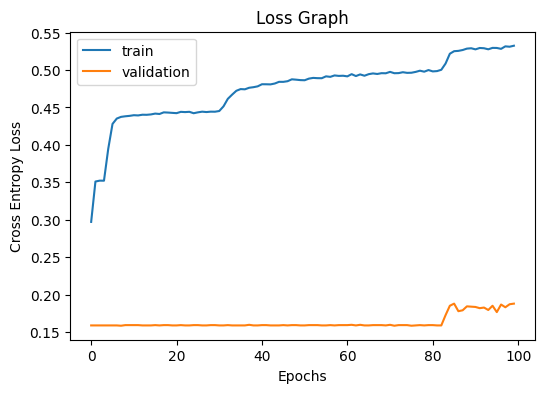

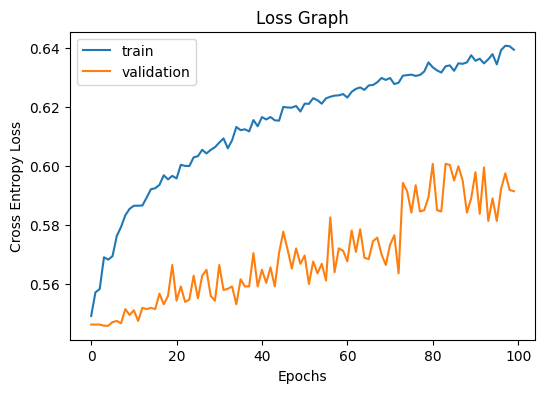

In [5]:
show_loss(train_avg_losses, val_avg_losses, (6, 4))
show_loss(train_accs_act, val_accs_act, (6, 4))
show_loss(train_accs_emo, val_accs_emo, (6, 4))

In [16]:
# saving model state
torch.save(model_EP.state_dict(), 'state/EP/EP5/model')

In [17]:
# saving loss values
with open('state/EP/EP5/train_avg_losses.pkl','wb') as f:
    pickle.dump(train_avg_losses, f)
with open('state/EP/EP5/val_avg_losses.pkl','wb') as f:
    pickle.dump(val_avg_losses, f)
with open('state/EP/EP5/train_accs_act.pkl','wb') as f:
    pickle.dump(train_accs_act, f)
with open('state/EP/EP5/val_accs_act.pkl','wb') as f:
    pickle.dump(val_accs_act, f)
with open('state/EP/EP5/train_accs_emo.pkl','wb') as f:
    pickle.dump(train_accs_emo, f)
with open('state/EP/EP5/val_accs_emo.pkl','wb') as f:
    pickle.dump(val_accs_emo, f)

### 3.3 Test

In [86]:
model_EP = model_EP.eval()
p = model_EP(train_keys['keys'].to(device))

In [87]:
p[1][0]

tensor([0.2040, 0.1622, 0.1962, 0.1101, 0.1070, 0.2205], device='cuda:0',
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [88]:
train_keys['emotion'][0]

tensor([0., 0., 0., 1., 0., 0.])

### 3.4 Loading
| EP | Batch Size | Epochs | Learning Rate | Linear Projection | Pad Masks | Val Regularize |
|----|------------|--------|---------------|-------------------|-----------|----------------|
| 1  | 256        | 1      | 2e-5          | X                 | X         | X              |
| 2  | 256        | 100    | 2e-5          | X                 | X         | X              |
| 3  | 256        | 1      | 2e-5          | O                 | X         | X              |
| 4  | 256        | 100    | 2e-5          | O                 | X         | X              |
| 5  | 256        | 100    | 2e-5          | O                 | X         | O              |

In [13]:
# loading previous model state
model_EP.load_state_dict(torch.load('state/EP/EP4/model'))

<All keys matched successfully>

In [2]:
# loading previous loss values
with open('state/EP/EP4/train_loss.pkl','rb') as f:
    loss_train = pickle.load(f)
with open('state/EP/EP4/val_loss.pkl','rb') as g:
    loss_val = pickle.load(g)

# Memo

Positional Embedding 문제  
Training set은 17 정도가 끝인데  
Val set은 0 ~ 178까지 다양하다  
learnable한 embedding을 사용한다면 17 이후의 embedding은 학습되지 않을 것이다.  